In [165]:
import warnings
warnings.filterwarnings("ignore") # ignore convergence warnings

# Data downloader
from sklearn.datasets import fetch_openml

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Metrics and model selection
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


sns.set_style('white')
%matplotlib inline

In [45]:
# Dataset details at- https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
y = y.astype('int')

In [46]:
# numerical features from the dataset
num_features = ['age', 'fare']
# categorical features from the dataset
cat_features = ['embarked', 'sex', 'pclass']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Acrescentar a clusterização como preprocessamento!

In [183]:
def create_model(algorithm, param_grid={}, metric='accuracy',
                 preprocessing_grid=False, use_smote=False, reduce_dim=False,
                 X_train=X_train, y_train=y_train, cv=5):
    
    global num_features, cat_features
    
    num_features_model = [i for i in num_features if i in X_train.columns]
    cat_features_model = [i for i in cat_features if i in X_train.columns]
    
    name = 'algorithm'
    if param_grid:
        param_grid = {name + '__' + k : v for k,v in param_grid.items() if name + '__' not in k}
    
    # Preprocess Numerical columns
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ])

    # Preprocess Categorical columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True)),
        ])

    column_transformer = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, num_features_model),
            ('categorical', categorical_transformer, cat_features_model),
        ])

    smote = None
    # Just useful if the dataset is imbalanced (around 85% of one class for binary problems)
    if use_smote:
        smote = SMOTE(random_state=0)
    
    pca = None
    # Obs: PCA does not improve the quality of the model, just helps it to train faster!
    if reduce_dim:
        pca = PCA(n_components=0.9)
    
        
    model = imbpipeline(steps=[('column_transformer', column_transformer), 
                               ('SMOTE', smote),
                               ('reduceDimensions', pca),
                               (name, algorithm),
                              ])
    
    
    if preprocessing_grid:
        preprocessing = {
        'column_transformer__numerical__imputer__strategy': ['mean', 'median'],
        'column_transformer__categorical__imputer__strategy': ['constant','most_frequent'],
        'column_transformer__numerical__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
        }
        
        param_grid.update(preprocessing)
    
    grid_search = GridSearchCV(model,
                               param_grid=param_grid,
                               scoring=metric,
                               n_jobs=-1,
                               cv=cv)
    
    grid_search.fit(X_train, y_train)
                            
    return grid_search

In [49]:
def plot_confusion_matrix(matrix):
    """Plots a complete confusion matrix for binary classification problems"""
    
    # Confusion matrix for binary data
    tags = ['True Neg','False Pos','False Neg','True Pos']
    labels = [f'{tag}\n{value}\n{np.round(value/np.sum(matrix.ravel()) * 100, 2)}%'
              for tag, value in zip(tags, matrix.ravel())]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, cmap='Blues', fmt='')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Original', fontsize=10)

    plt.show()

In [50]:
def evaluate_model(model, conf_matrix=True, X_test=X_test, y_test=y_test):
    """Receives a trained model and evaluate its performance on test data"""
    
    y_pred = model.predict(X_test)
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
    if conf_matrix:
        plot_confusion_matrix(confusion_matrix(y_test, y_pred))
    try:
        print(f'Best Params: {model.best_params_}')
    except:
        pass

In [190]:
def classification_fast_tests(metric='accuracy'):
    
    """The purpose of this function is to perform
    a fast test using the most commom classifiers.
    Some of them are heavily dependent on
    hyperparameters - so we will give them some
    After that we can pick only the top algorithms
    and make an larger hyperparameter search."""
    
    metrics = {'accuracy':'accuracy_score',
               'recall':'recall_score',
               'precision':'precision_score',
               'f1':'f1_score'}
    
    algorithms = ['LogisticRegression', 'GaussianNB', 'RandomForestClassifier',
                  'SVC', 'KNeighborsClassifier']
    
    
    LogisticRegression_params = {'C':[i for i in np.logspace(-1, 1, 3)]}
    GaussianNB_params = {}
    RandomForestClassifier_params = {}
    SVC_params = {'C':[i for i in np.logspace(-1, 1, 3)],
                  'gamma':[i for i in np.logspace(-1, 1, 3)]}
    KNeighborsClassifier_params = {'n_neighbors':[i*2 for i in range(10)]}
    
    parameters = [LogisticRegression_params, GaussianNB_params, RandomForestClassifier_params,
                 SVC_params, KNeighborsClassifier_params]
    
    results = {}
    for params, algorithm in zip(parameters, algorithms):
        model = create_model(algorithm=eval(algorithm)(),
                             param_grid=params,
                             metric=metric,
                             cv=3,
                            )
        
        y_pred = model.predict(X_test)
        
        
        performance = eval(metrics[metric])(y_test, y_pred)
        results[algorithm] = performance
        
    results = (pd.DataFrame.from_dict(
                                     results, orient='index', columns=[metric])
               .sort_values(by=metric, ascending=False))
    
    return results
classification_fast_tests(metric='f1')

,f1
KNeighborsClassifier,0.719512
LogisticRegression,0.705882
SVC,0.683871
GaussianNB,0.683417
RandomForestClassifier,0.662857


,0,1,accuracy,macro avg,weighted avg
precision,0.849398,0.687500,0.790076,0.768449,0.793166
recall,0.824561,0.725275,0.790076,0.774918,0.790076
f1-score,0.836795,0.705882,0.790076,0.771339,0.791326
support,171.000000,91.000000,0.790076,262.000000,262.000000


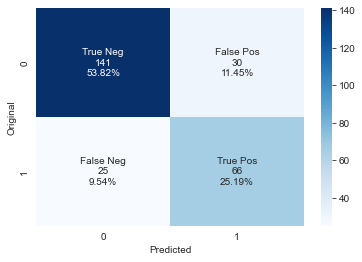

Best Params: {'algorithm__C': 1.0, 'algorithm__solver': 'liblinear'}


In [51]:
param_grid = {
    'C': [i for i in np.logspace(-2, 2, 5)],
    'solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}

# fitting on our dataset
model = create_model(algorithm=LogisticRegression(max_iter=100),
                    param_grid=param_grid,
                    metric='accuracy',
                    preprocessing_grid=False,
                    use_smote=False,
                    reduce_dim=False,
                    )

evaluate_model(model)

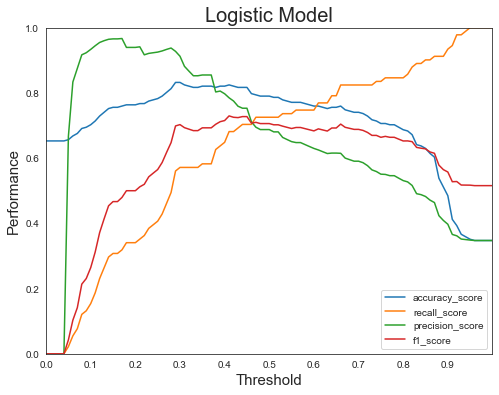

Best accuracy_score = 0.83; Best Thresh = 29
Best recall_score = 1.0; Best Thresh = 95
Best precision_score = 0.97; Best Thresh = 17
Best f1_score = 0.73; Best Thresh = 41


In [164]:
def plot_thresholds(model, title, X_test=X_test, y_test=y_test):
    
    plt.figure(figsize=(8,6))
    metrics = ['accuracy_score', 'recall_score', 'precision_score', 'f1_score']
    results = {metric:{} for metric in metrics}

    for thresh in np.arange(0, 101)/100:
        proba = model.predict_proba(X_test)
        proba = np.where(proba[:,0]>thresh, 0, 1)

        for metric in metrics:
            results[metric][thresh] = (eval(metric)(y_test, proba))

    for metric in results:
        plt.plot(results[metric].keys(), results[metric].values(), label=metric)
    
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.xticks(np.arange(0, 100, 10)/100)
    plt.legend(loc='best')
    plt.title(title, fontsize=20)
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Performance', fontsize=15)
    plt.show()
    
    for metric in results.keys():
        values = np.array(list(results[metric].values()))
        print(f'Best {metric} = {np.round(np.max(values), 2)}; Best Thresh = {np.argmax(values)}')
    
plot_thresholds(model, 'Logistic Model')